# Another class of $5$-manifolds

This notebook illustrates the construction of the $4$-manifold $X$ and the related $5$-manifolds. \
The code is divided into the following sections:

- **The adjacency graph** \
    Construction of the graph $\mathcal G'$.
- **Finding real cliques** \
    Determination of the real cliques of the graph $\mathcal G'$ to construct $X$.
- **Homology of the $4$-manifold $X$** \
    Computation of the homology groups $H_i(X; \mathbb Z)$ using GAP.
- **Coloring the graph** \
    A $26$-coloring of the graph $\mathcal G'$ and some related $13$-colorings.
- **Visualization of the variety over $\mathbb F_5$** \
    A schematic 3D plot of the vertex set of $\mathcal G'$, for visualization purposes.
- **Linear binary code** \
    Construction of a linear binary code, whose columns provide a $\mathbb Z_2^9$-coloring of $Y$.

In [1]:
import itertools
import random
from collections import defaultdict

In [2]:
def multiset(it):
    d = defaultdict(int)
    for k in it:
        d[k] += 1
    return dict(d)

def multimap(it):
    d = defaultdict(set)
    for k,v in it:
        d[k].add(v)
    return dict(d)

## The adjacency graph

First, we define a Coxeter group `G`, which has a linear representation over $\mathbb Z[\varphi]$:

In [3]:
gr = Graph([(0,1,5),(1,2,3),(2,3,3),(3,4,3)])
Zphi.<phi> = ZZ[(sqrt(5)+1)/2]
G = CoxeterGroup(gr, base_ring=Zphi)

Then, we define the quotient map `q` on matrices, induced by the ideal $(\varphi-3)$:

In [4]:
F5 = ResidueField(Zphi.fractional_ideal(phi-3))

In [5]:
red = F5.reduction_map()

In [6]:
q = lambda m: matrix(m.nrows(), m.ncols(), lambda i,j: GF(5)(red(m[i,j])))

In [7]:
J = q(G.bilinear_form())

We diagonalize the $\bmod 5$ quadratic form:

In [8]:
diag, P = QuadraticForm(J).rational_diagonal_form(return_matrix=True)

In [9]:
assert(P * diag.matrix()^-1 * P.T == J^-1)

In [10]:
K = diag.matrix()^-1
gens = [P^-1 * q(m.matrix()) * P for m in G.gens()]
assert(all(m * K * m.T == K for m in gens))

In [11]:
K

[1 0 0 0 0]
[0 1 0 0 0]
[0 0 1 0 0]
[0 0 0 1 0]
[0 0 0 0 3]

In [12]:
gens

[
[4 0 0 0 0]  [4 3 1 0 0]  [1 0 0 0 0]  [1 0 0 0 0]  [1 0 0 0 0]
[0 1 0 0 0]  [3 4 1 0 0]  [0 1 0 0 0]  [0 4 1 3 0]  [0 1 0 0 0]
[0 0 1 0 0]  [1 1 3 0 0]  [0 0 4 0 0]  [0 1 3 1 0]  [0 0 1 0 0]
[0 0 0 1 0]  [0 0 0 1 0]  [0 0 0 1 0]  [0 3 1 4 0]  [0 0 0 3 2]
[0 0 0 0 1], [0 0 0 0 1], [0 0 0 0 1], [0 0 0 0 1], [0 0 0 1 2]
]

Heuristically, a $120$-cell is represented by its center,
which is given by the intersection of the fixed hyperplanes of the first $4$ generators.

In [13]:
planes = [b for g in gens for a,b in g.eigenspaces_left() if a == 1]

In [14]:
inv_ssp = GF(5)^5
for j in range(4):
    inv_ssp = inv_ssp.intersection(planes[j])
v0 = vector(q(inv_ssp.basis_matrix()), immutable=True)
v0

(0, 0, 0, 0, 1)

In [15]:
v0 * K * v0

3

In [16]:
Q = MatrixGroup(gens)

In [17]:
Q.cardinality()

9360000

The stabilizer of $v_0$ under the action of $Q$ has the correct size:

In [18]:
assert(libgap.Stabilizer(Q, v0).Size() == 14400)

We construct the orbit, while storing for each point $v$ a matrix $m$ such that $v_0 m = v$.
(In GAP, matrices act on the right.)

In [19]:
rtv = libgap.RightTransversal(Q, libgap.Stabilizer(Q, v0)).AsList()

In [20]:
%%time
vector_to_isometry = {vector(v0*matrix(m), immutable=True): matrix(m) for m in rtv}
orbit = sorted(vector_to_isometry)
vector_to_index = {k: i for i,k in enumerate(orbit)}

CPU times: user 259 ms, sys: 27 μs, total: 259 ms
Wall time: 259 ms


In [21]:
N_CELLS = len(orbit); N_CELLS

650

The stabilizer $\Sigma$ (or, more properly, $q(\Sigma)$):

In [29]:
stab = MatrixGroup(gens[:-1])

The edges of the graph $\mathcal G'$ can be constructed as the orbit of a pair of adjacent cells.

If $R$ is a right transversal for the stabilizer $\Sigma$ (i.e. $Q = \Sigma R$), then the orbit can be computed as:
$$
(v_0, \varepsilon v_0)\cdot Q = (v_0, \varepsilon v_0)\cdot \Sigma R = 
(v_0, \varepsilon v_0\cdot \Sigma)\cdot R 
$$

In [30]:
adj = v0*gens[4]

In [31]:
star_v0 = [vector(v, immutable=True) for v in libgap.Orbit(stab, adj).sage()]

In [32]:
len(star_v0)

120

In [33]:
%%time
edges = [(vector_to_index[k], vector_to_index[vector(p*m, immutable=True)])
                for k, m in vector_to_isometry.items() for p in star_v0]
len(edges)

CPU times: user 291 ms, sys: 818 μs, total: 292 ms
Wall time: 292 ms


78000

An alternate description of the edges of $\mathcal G'$:

In [34]:
%time edges_alt = [(j,k) for j in range(N_CELLS) for k in range(N_CELLS) if orbit[j] * K * orbit[k] == 1]

CPU times: user 450 ms, sys: 4.96 ms, total: 455 ms
Wall time: 457 ms


In [35]:
set(edges) == set(edges_alt)

True

The graph $\mathcal G'$ (`graph`) and some related objects:

In [37]:
graph = Graph(edges)

In [38]:
aut = graph.automorphism_group()

In [39]:
all_cliques = sorted(tuple(sorted(t)) for t in graph.all_cliques())

In [40]:
len(all_cliques)

156000

## Finding real cliques

### Slower method

Define the set of real cliques as the orbit of a specific clique:

In [41]:
real_clique = (
    v0, 
    v0 * gens[4],
    v0 * gens[4] * gens[3],
    v0 * gens[4] * gens[3] * gens[2],
    v0 * gens[4] * gens[3] * gens[2] * gens[1]
)

real_clique_mat = matrix(real_clique)
real_clique_mat_inv = real_clique_mat^-1
real_clique_mat.set_immutable()
real_clique_mat_inv.set_immutable()

In [42]:
real_clique_mat

[0 0 0 0 1]
[0 0 0 1 2]
[0 3 1 4 2]
[0 3 4 4 2]
[3 1 0 4 2]

In [43]:
def is_clique_real(cl):
    return real_clique_mat_inv * matrix(orbit[j] for j in cl) in Q

The stabilizer of a clique is simply the permutation group on its vertices:

In [44]:
%%time
real_clique_stab = Q.subgroup([
    real_clique_mat_inv * Permutation(p).to_matrix().change_ring(GF(5)) * real_clique_mat
    for p in ([2,1,3,4,5], [2,3,4,5,1])
])
clique_transversal = [matrix(m) for m in libgap.RightTransversal(Q, real_clique_stab).AsList()]
len(clique_transversal)

CPU times: user 17.2 s, sys: 26.1 ms, total: 17.3 s
Wall time: 17.3 s


78000

In [54]:
%%time
all_real_cliques_slow = [tuple(sorted(vector_to_index[r] for r in (real_clique_mat*m).rows())) for m in clique_transversal]

CPU times: user 1.68 s, sys: 2.93 ms, total: 1.69 s
Wall time: 1.69 s


### Faster method

This method is about twice as fast as the previous one,
and relies on a realization of the $600$-cell in $\mathbb R^4$. \
It has $120$ vertices, given by Coxeter (_Regular Polytopes_ (3rd ed.), New York: Dover, pp. 156-157):

-  $8$ of the form $(0, 0, 0, \pm 1)$ and permutations;
- $16$ of the form $(\pm 1/2⁠, \pm 1/2⁠, \pm 1/2⁠, \pm 1/2⁠)$;
- $96$ of the form $(\pm \varphi/2⁠, \pm 1/2⁠, \pm \varphi^{-1}/2⁠, 0)$ and _even_ permutations.

Modulo $5$, these become:

-  $8$ of the form $(0, 0, 0, \pm 1)$ and permutations;
- $16$ of the form $(\pm 3, \pm 3⁠, \pm 3⁠, \pm 3⁠)$;
- $96$ of the form $(\pm 4⁠, \pm 3, \pm 1⁠, 0)$ and even permutations.

Since $\varphi/2$ and $-\varphi^{-1}/2$ become indistinguishable modulo $5$, the word "even" fails to have any effect, \
and odd permutations also get included. This ultimately introduces virtual cliques.

The following function recovers the $\mathbb Z[\varphi]$-coordinates of adjacent vertices of `v` from their $\mathbb F_5$-coordinates, \
by assuming that in the third case ($96$ vertices) the permutation of $(\pm \varphi/2⁠, \pm 1/2⁠, \pm \varphi^{-1}/2⁠, 0)$ is even.

In [36]:
@cached_function
def get_special_edges(v):
    twice_vtx = {}
    nb = graph[v]
    val = float(4 * (2 - phi))
    phifp = float(phi)
    for j in nb:
        disp = (orbit[j] * vector_to_isometry[orbit[v]]^-1)[:-1]
        if sum(1 for x in disp if x == 0) == 3:
            twice_vtx[j] = vector(RDF, [[0,2,0,0,-2][x] for x in disp], immutable=True)
        elif sum(1 for x in disp if x in (2,3)) == 4:
            twice_vtx[j] = vector(RDF, [[0,0,-1,1,0][x] for x in disp], immutable=True)
        else:
            i0 = [k for k,x in enumerate(disp) if x == 0][0]
            i3 = [k for k,x in enumerate(disp) if x in (2,3)][0]
            i4, i1 = [k for k,x in enumerate(disp) if x in (1,4)]
            if Permutation([i4+1,i3+1,i1+1,i0+1]).sign() == -1:
                i1, i4 = i4, i1
            entries = [0,0,0,0]
            entries[i1] = phifp-1
            entries[i3] = 1
            entries[i4] = phifp
            if disp[i1] != 1: entries[i1] *= -1
            if disp[i3] != 3: entries[i3] *= -1
            if disp[i4] != 4: entries[i4] *= -1
            twice_vtx[j] = vector(RDF, entries, immutable=True)
    special_edges = set()
    for i,j in itertools.combinations(sorted(nb), 2):
        if not graph.has_edge(i,j):
            continue
        dist = twice_vtx[i] - twice_vtx[j]
        if (sum(x^2 for x in dist) - val) > 3e-3:
            special_edges.add((i,j))
            
    return special_edges

In [50]:
%time for j in range(N_CELLS): get_special_edges(j)

CPU times: user 9.71 s, sys: 89.7 ms, total: 9.8 s
Wall time: 9.83 s


In [51]:
def is_clique_real(cl):
    for a in cl:
        for b,c in itertools.combinations(cl,2):
            if a not in (b,c):
                if (b,c) in get_special_edges(a):
                    return True
    return False

In [52]:
%%time
all_real_cliques_fast = [cl for cl in all_cliques if is_clique_real(cl)]

CPU times: user 607 ms, sys: 0 ns, total: 607 ms
Wall time: 608 ms


In [55]:
sorted(all_real_cliques_slow) == sorted(all_real_cliques_fast)

True

### Renaming the list of cliques

In [56]:
try:
    all_real_cliques = all_real_cliques_slow
except NameError:
    all_real_cliques = all_real_cliques_fast

In [57]:
len(all_real_cliques)

78000

## Homology of the $4$-manifold $X$

In [75]:
libgap.load_package("HAP")

true

In [76]:
%time sc = libgap.SimplicialComplex(list(all_real_cliques))

CPU times: user 2.6 s, sys: 39 ms, total: 2.63 s
Wall time: 2.61 s


In [92]:
def homology_group_description(ab):
    """
    Returns a string describing the structure of an abelian group,
    given a dictionary (multiset) of abelian invariants ab.

    Example: [0, 0, 2, 2, 4, 5] --> "Z^2 + Z_2^2 + Z_4 + Z_5"
    """
    subscript = lambda m: f"_{m}" if m else ""
    exponent = lambda ex: f"^{ex}" if ex > 1 else ""
    return " + ".join("Z" + subscript(m) + exponent(ex) for m, ex in sorted(ab.items()))

In [93]:
%%time
homology = []
for j in range(5):
    ab = multiset(libgap.Homology(sc, j).sage())
    homology.append(ab)
    print(f"H_{j}(X; Z) = {homology_group_description(ab)}", flush=True)

H_0(X; Z) = Z
H_1(X; Z) = Z^144
H_2(X; Z) = Z^936
H_3(X; Z) = Z^144
H_4(X; Z) = Z
CPU times: user 16min 25s, sys: 4.68 s, total: 16min 30s
Wall time: 16min 26s


In [95]:
euler_char = sum((-1)^d * ab[0] for d, ab in enumerate(homology))
euler_char, euler_char == N_CELLS

(650, True)

## Coloring the graph

In [58]:
sorted(multiset(graph.adjacency_matrix().eigenvalues()).items())

[(-10, 246), (-5, 104), (0, 65), (10, 130), (15, 104), (120, 1)]

Let $\lambda_1$ and $\lambda_n$ be the largest and smallest eigenvalues of $\mathcal G'$, respectively. \
By the Hoffman bound, the chromatic number of $\mathcal G'$ is at least $1 - \lambda_1 / \lambda_n = 13$.

Indeed, we shall construct a $26$-coloring (where the colors are orbits of a subgroup $L < \operatorname{Aut}(\mathcal G')$), \
and then pair the colors together, to obtain some $13$-colorings.

In [67]:
def matrix_as_permutation(m):
    perm = [vector_to_index[vector(v * m, immutable=True)] for v in orbit]
    return aut(SymmetricGroup(range(N_CELLS))(perm))

In [60]:
def as_permutation_group(mat_grp):
    return aut.subgroup([matrix_as_permutation(m) for m in mat_grp.gens()])

In [61]:
autQ = as_permutation_group(Q)

In [63]:
autQ.cardinality() == Q.cardinality()

True

Now, let us look for an automorphism subgroup $L$ whose orbits are independent sets and have equal sizes.

In [62]:
%time autQcc = autQ.conjugacy_classes_subgroups()

CPU times: user 22.5 s, sys: 204 ms, total: 22.7 s
Wall time: 23.1 s


In [70]:
def test_permgroup(grp):
    remaining = set(range(N_CELLS))
    orbit_lengths = []
    while remaining:
        vert = next(iter(remaining))
        orb = tuple(sorted(grp.orbit(vert)))
        if not graph.is_independent_set(orb):
            return None
        if orbit_lengths and len(orb) != orbit_lengths[-1]:
            return None
        orbit_lengths.append(len(orb))
        for j in orb:
            remaining.remove(j)
    return orbit_lengths

In [72]:
%%time 
good_indices = []
for j,grp in enumerate(autQcc):
    result = test_permgroup(grp)
    if result:
        good_indices.append(j)
        print(f"Subgroup #{j} of size {grp.cardinality()}: ".ljust(40, "."), end = " ")
        print(", ".join(f"{b} orbits of size {a}" for a,b in multiset(result).items()))
        print()

Subgroup #0 of size 1: ................. 650 orbits of size 1

Subgroup #567 of size 125: ............. 26 orbits of size 25

CPU times: user 672 ms, sys: 2.97 ms, total: 675 ms
Wall time: 677 ms


Due to non-determinism, here we define a representative for this conjugacy class:

In [73]:
Lm = [
    matrix(GF(5),
           [[0,4,1,4,4],
            [3,0,1,2,3],
            [2,1,0,3,2],
            [0,4,1,2,0],
            [2,2,3,2,3]], immutable=True),
    matrix(GF(5),
           [[1,3,0,3,3],
            [2,2,3,1,1],
            [0,2,1,2,2],
            [2,1,3,2,1],
            [1,3,4,3,4]], immutable=True)]

L = as_permutation_group(MatrixGroup(Lm))

In [74]:
%time assert(libgap.IsConjugate(autQ, L, autQcc[good_indices[-1]]))

CPU times: user 7.12 ms, sys: 965 μs, total: 8.09 ms
Wall time: 7.99 ms


Check that it is a coloring:

In [96]:
orbits_L = sorted(tuple(sorted(t)) for t in L.orbits())
assert(all(graph.is_independent_set(orb) for orb in orbits_L))

In [99]:
N_COLORS = len(orbits_L); N_COLORS

26

In [100]:
colors = {vert: col for col, orb in enumerate(orbits_L) for vert in orb}

Find "distant pairs" of colors (pairs of colors that never touch):

In [104]:
%%time
distant_pairs = set(itertools.combinations(range(N_COLORS), 2))
for u, v in edges:
    cu = colors[u]
    cv = colors[v]
    if cu > cv:
        cu, cv = cv, cu
    distant_pairs.discard((cu, cv))

distant_pair_graph = Graph(list(distant_pairs))

CPU times: user 17.3 ms, sys: 2 μs, total: 17.3 ms
Wall time: 27 ms


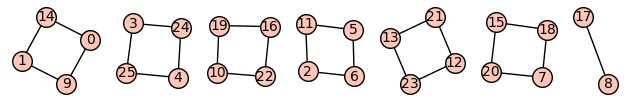

In [106]:
distant_pair_graph.plot()

In [110]:
dpg_cc = sorted(distant_pair_graph.connected_components(sort=True), key=lambda l: (-len(l), l))
dpg_cc

[[0, 1, 9, 14],
 [2, 5, 6, 11],
 [3, 4, 24, 25],
 [7, 15, 18, 20],
 [10, 16, 19, 22],
 [12, 13, 21, 23],
 [8, 17]]

Colors can be paired in $2^6=64$ different ways:

In [114]:
matchings_by_component = []
for cc in dpg_cc[:-1]:
    root = cc[0]
    a,b = sorted(distant_pair_graph[root])
    d,  = list(set(cc[1:]).difference((a,b)))
    matchings_by_component.append(
        [
            ((root, a), (b, d)),
            ((root, b), (a, d))
        ]
    )
    cc[1],cc[2],cc[3] = a,d,b
matchings_by_component.append(
    [
        (tuple(dpg_cc[-1]),)
    ]
)

In [117]:
all_matchings = [
    [edge for matching in t for edge in matching]
    for t in itertools.product(*matchings_by_component)
]

In [118]:
len(all_matchings)

64

Choose a matching:

In [122]:
MATCHING_INDEX = 0

In [123]:
matching = all_matchings[MATCHING_INDEX]

merged_orbits_L = [[vert for col in t for vert in orbits_L[col]] for t in matching]
merged_colors = {vert: col for col, orb in enumerate(merged_orbits_L) for vert in orb}

In [124]:
all(merged_colors[a] != merged_colors[b] for a,b in graph.edges(labels=False))

True

## Visualization of the variety over $\mathbb F_5$

We visualize the vertex set of $\mathcal G'$, which is a smooth quadric over $\mathbb F_5$, \
by embedding it in $\mathbb R^5$ (with coordinates in $\{-2,-1,0,1,2\}$), and plotting it, by interpreting:

- the last three dimensions as coordinates in $\mathbb R^3$ and
- the first two dimensions as coordinates in a small square around the point.

In [126]:
EPS = 0.05
EMBEDDING = matrix([[EPS, 0.0, 0.0],
                    [0.0, EPS, 0.0],
                    [1.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0],
                    [0.0, 0.0, 1.0]])
def plot_variety_point(v):
    vr = v.change_ring(RDF)
    for i in range(5):
        if vr[i] > 2.5:
            vr[i] -= 5
    return vr * EMBEDDING

In [128]:
def plot_variety(col = -1, vert = -1, color_partition = None):
    """
    Plots the smooth variety associated to the vertex set of the graph.
    The variety, a subset of F_5^5, is embedded into 3-space and color-coded according to a specified coloring.

    ARGUMENTS:
    - col:             if given, a specific color (index) to highlight with semitransparent spheres
    - vert:            if given, a specific vertex (index) whose star will be drawn
    - color_partition: a list such that color_partition[j] is a collection of all vertices of color j
                       (if not given, merged_orbits_L will be used)
    """
    if color_partition is None:
        color_partition = merged_orbits_L
    n_colors = len(color_partition)
    plt = sum(
        list_plot([plot_variety_point(orbit[v]) for v in orb],
                  size=10, color = hue(_col/n_colors))
        for _col, orb in enumerate(color_partition)
    )
    if col != -1:
        plt += sum(
            sphere(plot_variety_point(orbit[j]),
                   0.15, opacity=0.25, color=Color(hue(col/n_colors)).lighter(0.5))
            for j in color_partition[col])
    if vert != -1:
        plt += sum(
            line([plot_variety_point(orbit[vert]), plot_variety_point(orbit[b])],
                 opacity=1, color="automatic")
            for b in graph[vert])
    return plt

In [137]:
show(plot_variety(col=12, vert=0), figsize = (10,10))

Graphics3d Object

In [133]:
show(plot_variety(col=3, vert=0, color_partition=orbits_L), figsize = (10,10))

Graphics3d Object

## Linear binary code

We construct a binary code of length $13$ and dimension $9$ which is dual to a code with minimum distance $6$.

> _***Note:***_ The following cell may issue a warning, which can be ignored.

In [2]:
qr17 = codes.QuadraticResidueCode(17, GF(2))

In [3]:
qr17e = codes.ExtendedCode(qr17)

In [5]:
code = qr17e.shortened([13,14,15,16,17])

In [8]:
code.minimum_distance()

6

Generating matrix for the dual code:

In [6]:
color_matrix = code.parity_check_matrix(); color_matrix

[1 0 0 0 0 0 0 0 0 1 0 0 1]
[0 1 0 0 0 0 0 0 0 0 1 0 0]
[0 0 1 0 0 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 0 0 0 1 0 0 0]
[0 0 0 0 1 0 0 0 0 1 1 0 1]
[0 0 0 0 0 1 0 0 0 1 1 1 1]
[0 0 0 0 0 0 1 0 0 1 1 1 0]
[0 0 0 0 0 0 0 1 0 0 1 1 1]
[0 0 0 0 0 0 0 0 1 0 0 1 1]